## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import string
from datetime import datetime
import numpy as np

#The tensorflow library
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

#append path with python modules
import importlib
import sys
sys.path.append("modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

2023-12-18 09:39:02.890013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

# Zbiór EMNIST

Jako zbiorów treningowych do analizy obrazów użyjemy rozszerzonego zbioru MNIST - 
[EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset)
zawierającego dużą liczbę zdjęć ręcznie pisanych liter i cyfr. Zdjęcia mają rozdzielczość `28x28` pikseli, 
a każdy piksel koduje poziom szarości w 8 bitowej skali.

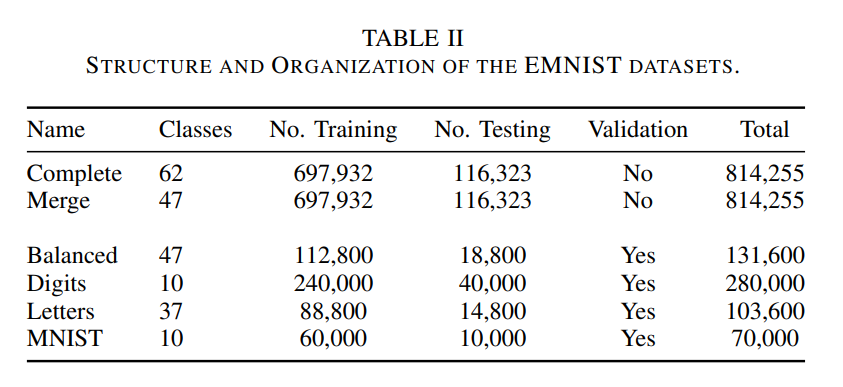

# Przygotowanie danych

**Proszę:**

* pobrać zbiór EMNIST
* napisać funkcję `getEMNIST(datasetName, datasetPath)` która zwróci krotkę `(features, labels)` dla zbioru o nazwie odpowiadającej nazwie odpowiedniego pliku, np.:
  ```Python
  
  x, y = getEMNIST('emnist-digits-train', datasePath)
  
  ```
  <br></br>
* po dopracowaniu kodu funkcji umieścić ją w module `modules/emnist_functions.py`  
* rozpakować dane treningowe dla liczb: `emnist-digits-train`
* przeskalować wartości do zakresu 0,1
* wydzielić z 40 000 przykładów na zbiór walidacyjny

**Uwagi:** 

* pliki są duże. Optymalnie jest pobrać - na dysk Google lub na lokalny dysk
* dane są zapisane w binarnym formacie IDX. Do ich dekodowania można użyć pakietu `idx2numpy`. Pakiet można doinstalować
  do aktualnej sesji korzystając z komendy `pip`. W komórce notatnika komendy linii poleceń trzeba poprzedzić wykrzyknikiem: 
  ```Shell
  
  !pip install idx2numpy
  ```
* zamiast wydzielania explicite zbioru walidacyjnego można użyć parametru `validation_split` metody `keras.model.fit()`:
  ```Python
  
  history = model.fit(x=x_train, y=y_train, 
                    epochs=nEpochs, 
                    batch_size = batchSize,
                    validation_split=0.1,   #ze zbioru treningowego 10% na zbiór walidacyjny 
                    callbacks=callbacks,
                    verbose=0)
  ```

In [2]:
!pip install idx2numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
#BEGIN_SOLUTION
def getEMNIST(datasetName, datasetPath):
    
    import idx2numpy
    fileName = datasetPath+"/"+datasetName+'-images-idx3-ubyte'
    features = idx2numpy.convert_from_file(fileName)

    fileName = datasetPath+"/"+datasetName+'-labels-idx1-ubyte'
    labels = idx2numpy.convert_from_file(fileName)
    return (features, labels)

datasetName = "emnist-digits-train"
datasetPath = "data/EMNIST/gzip/"
features, labels = getEMNIST(datasetName, datasetPath)

nTrainExamples = 50000
nValExamples = 10000
x_train = features[:nTrainExamples]
y_train = labels[:nTrainExamples]

x_val = features[-nValExamples:]
y_val = labels[-nValExamples:]

print(colored("Training data shapes: ","blue"), x_train.shape, y_train.shape)
print(colored("Validation data shapes: ","blue"), x_val.shape, y_val.shape)
#END_SOLUTION
pass

Training data shapes:  (50000, 28, 28) (50000,)
Validation data shapes:  (10000, 28, 28) (10000,)


**Proszę:**

* napisać funkcję `plotMNIST(x, y, y_pred)`, która rysuje cztery losowe obrazy podpisane dwoma rodzajami etykiet
  zawartych w macierzach `y` i `y_pred`
* po dopracowaniu kodu funkcji umieścić ją w module `modules/emnist_functions.py`  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


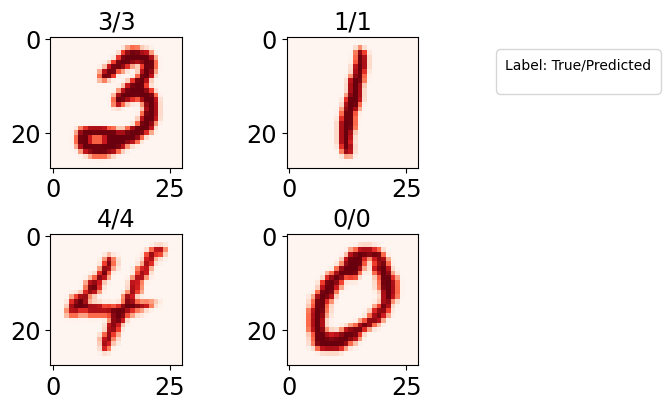

In [4]:
#BEGIN_SOLUTION
def plotMNIST(x, y, y_pred): 
    indices = np.random.default_rng().integers(0, len(x), (4))
    fig, axes = plt.subplots(2, 2, figsize=(4.5,4.5))

    for index, axis in zip(indices, axes.flatten()): 
        title = "Predicted={}, True={}".format(y[index],y_pred[index])
        axis.imshow(x[index].T, cmap=plt.get_cmap('Reds'), label="A")
        axis.set_title(title)

    axes[0,1].legend(bbox_to_anchor=(1.5,1), loc='upper left', title="Label: True/Predicted") 
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.4, hspace=0.5)

plotMNIST(x_train, y_train, y_train)
#END_SOLUTION
pass

**Proszę:**

* wywołać funkcje ładującą dane i rysującą rysunki korzystając z modułu `emnist_functions`

2023-12-18 09:39:06.589494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-18 09:39:06.589518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 94b1ec4ee457
2023-12-18 09:39:06.589524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 94b1ec4ee457
2023-12-18 09:39:06.589587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-12-18 09:39:06.589607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2023-12-18 09:39:06.591834: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-12-18 09:39:06.666885: W tensorflow/tsl/framework/cpu_allo

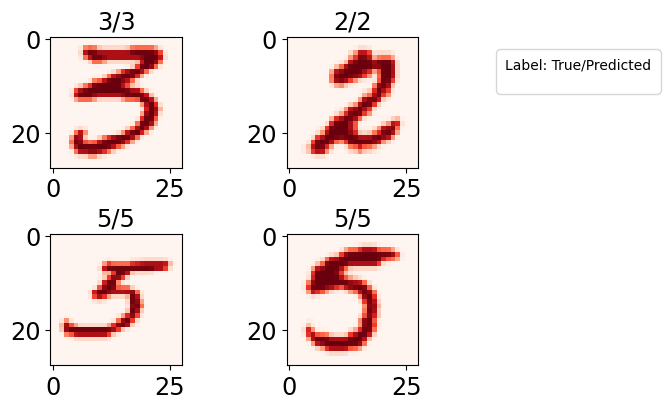

In [5]:
#BEGIN_SOLUTION
import emnist_functions as emnist_fcn

datasetName = "emnist-digits-train"
datasetPath = "/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/data/EMNIST/gzip/"
x, y = emnist_fcn.getEMNIST(datasetName, datasetPath)
emnist_fcn.plotMNIST(x, y, y)
#END_SOLUTION
pass

**Proszę:**

  * narysować histogramy krotności poszczególnych klas dla zbiorów treningowego i walidacyjnego

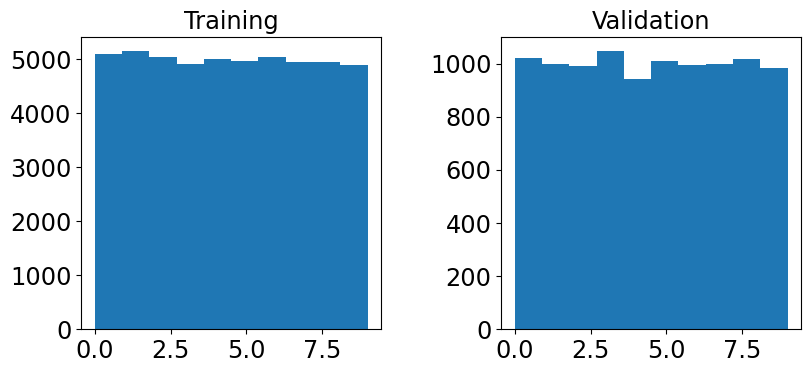

In [6]:
#BEGIN_SOLUTION
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].hist(y_train);
axes[0].set_title("Training")

axes[1].hist(y_val);
axes[1].set_title("Validation")
plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.4, hspace=0.5)
#END_SOLUTION
pass

Mamy przed sobą zagadnienie kategoryzacji z wieloma klasami. Etykiety klas są podane w postaci numeru klasy:
```Python
print(y_train[:3])
[8 9 6]
```

Sieć, którą skonstruujemy, będzie estymowała prawdopodobieństwo przynależności do klasy na podstawie cech:

$$
{\huge
f_{g}(x) =  P(g|x)
}
$$

następnie użyjemy klasyfikacji Bayesa przypisując klasę o maksymalnym prawdopodobieństwie:

$$
{\huge
g = argmax_{g \in G} f_{g}(x)
}
$$

Jako funkcji straty użyjemy entropii krzyżowej dla wielu kategorii. Mamy do wyboru dwa warianty:

* `sparse_categorical_crossentropy` - implementacja zakładająca, że etykiety zawierają numery klas

* `categorical_crossentropy` - implementacja zakładająca, że etykiety zawierają wektory prawdopodobieństw przynależności do klas:

```Python
x = tf.one_hot(y_train[:3], 10)
print(x)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(3, 10), dtype=float32)
```  

W naszym przypadku każdy przykład należy do jednej klasy, więc wektor prawdopodobieństw zawiera zerach, z wyjątkiem elementu odpowiadającego klasie, do której należy przykład. Taka reprezentacja nazywa się gorąco jedynkową, ang. `one_hot`


* warstwa wyjściowa ma teraz liczbę neuronów równa liczbie klas - każdy neuron zwraca prawdopodobieństwo przynależności do danej klasy
* funkcja aktywacji warstwy wyjściowej powinna być ustawiona na `softmax` by zapewnić normalizację prawdopodobieństwa przykładu do 1:

$$
{\huge
\sum _{g} f_{g}(x) =  1
}
$$

**Proszę:**

* skonstruować  sieć w pełni połączoną rozpoznającą ręcznie napisaną cyfrę. Sieć powinna mieć ``128`` neuronów w każdej z
  ``16`` warstw.
* przeprowadzić trening i narysować zmianę funkcji straty
* skomentować wykresy funkcji straty - **Czy widać na nich oznaki przetrenowania?**

**Uwaga:** proszę zwrócić uwagę na kształt danych wejściowych

Evaluation on training dataset:
1563/1563 [==============================] - 1s 929us/step - loss: 0.0033 - accuracy: 0.9991
Evaluation on validation dataset:
313/313 [==============================] - 0s 930us/step - loss: 0.2203 - accuracy: 0.9811
CPU times: user 14min 14s, sys: 44.1 s, total: 14min 58s
Wall time: 5min 43s


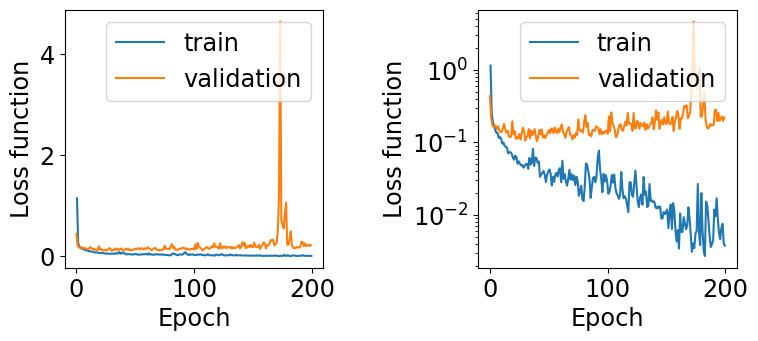

In [7]:
%%time
#BEGIN_SOLUTION
inputShape = (28,28)

nNeurons = np.full((16),128)
nOutputNeurons = 10

def getModel(inputShape, nNeurons, hiddenActivation="relu", outputActivation="linear", nOutputNeurons=1):
   
    inputs = tf.keras.Input(shape=inputShape, name="features")
    x = tf.keras.layers.Flatten()(inputs)
    
    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation, 
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  kernel_initializer="HeNormal",
                                  #kernel_regularizer=tf.keras.regularizers.L2(l2=0.01),
                                  name="layer_"+str(iLayer))(x)
                
    outputs = tf.keras.layers.Dense(nOutputNeurons, activation=outputActivation, name = "output")(x)   
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    return model

model = getModel(inputShape=inputShape, nOutputNeurons=nOutputNeurons, 
                 nNeurons=nNeurons, 
                 hiddenActivation="relu", 
                 outputActivation="softmax")

#configure learning process
initial_learning_rate = 1E-3
batchSize = 64
nEpochs = 200

nStepsPerEpoch = len(x_train)/batchSize
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#run training
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1E-3)
#callbacks = [early_stop_callback]
callbacks = []

history = model.fit(x=x_train, y=y_train, 
                    epochs=nEpochs, 
                    batch_size = batchSize,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=0)
plf.plotTrainHistory(history)
print(colored("Evaluation on training dataset:","blue"))
model.evaluate(x_train, y_train)
print(colored("Evaluation on validation dataset:","blue"))
model.evaluate(x_val, y_val)
#END_SOLUTION
pass

**Proszę:**

* użyć kryterium Bayesa do skonstruowania finalnej odpowiedzi modelu - `do której klasy należy dany przykład`
* narysować macierz pomyłek dla zbioru treningowego i walidacyjnego
* macierze pomyłek proszę znormalizować względem prawdziwych etykiet.

313/313 [==============================] - 0s 867us/step


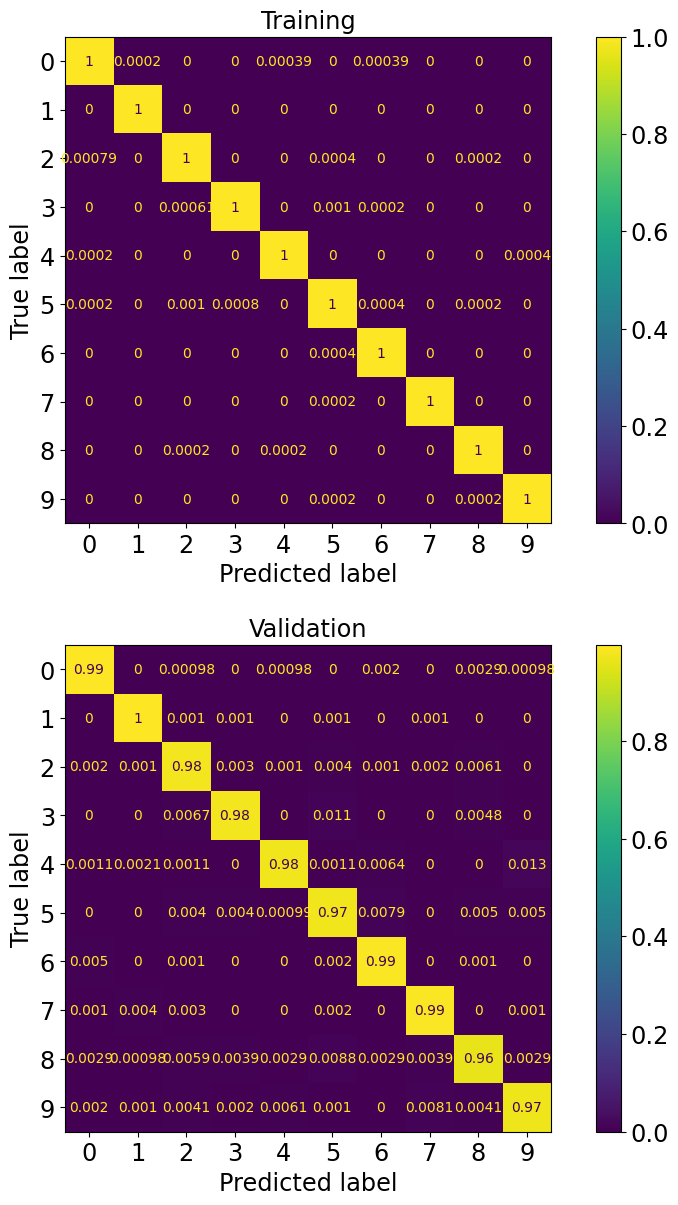

In [8]:
#BEGIN_SOLUTION
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 1, figsize=(10,15))
y_pred = tf.argmax(model.predict(x_train), axis=1)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize="true", ax=axes[0])

y_pred = tf.argmax(model.predict(x_val), axis=1)
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, normalize="true", ax=axes[1])

axes[0].set_title("Training")
axes[1].set_title("Validation")
plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.25)
#END_SOLUTION
pass

**Proszę:**

* narysować cztery losowe przykłady z informacją etykietach: prawdziwej i przyznanej przez model
* narysować cztery przykłady, w których odpowiedź modelu nie jest poprawna

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


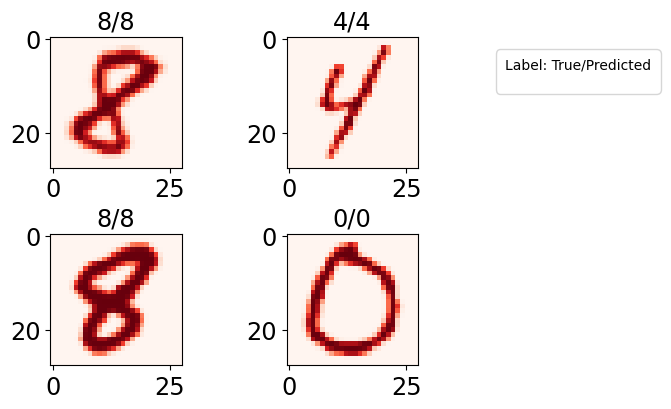

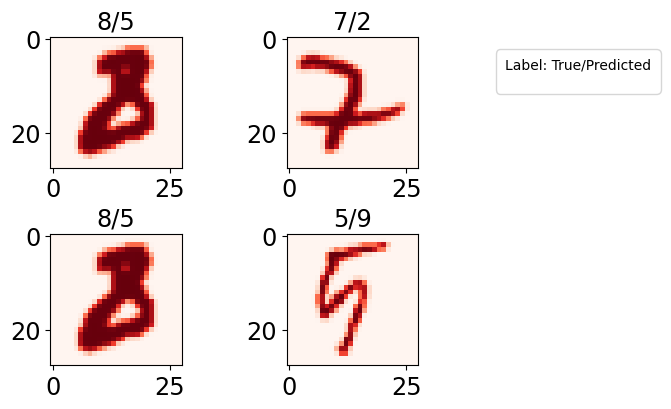

In [9]:
#BEGIN_SOLUTION
plotMNIST(x_val, y_val, y_pred)
mask = y_val!=y_pred
plotMNIST(x_val[mask], y_val[mask], y_pred[mask])
#END_SOLUTION
pass

## Zapis modelu

Model stworzony w Keras może być zapisany w całości - struktura i wagi lub jako same wagi.
W nazwie pliku modelu warto zakodować podstawowe meta dane o treningu, np. datę i liczbę epok.

In [10]:
currentTime = datetime.now().strftime("%b_%d_%Y_%H_%M")
path = "training/{epoch:04d}_"+currentTime
model.save(path.format(epoch=nEpochs), save_format='tf');

INFO:tensorflow:Assets written to: training/0200_Dec_18_2023_09_44/assets


INFO:tensorflow:Assets written to: training/0200_Dec_18_2023_09_44/assets


## Wczytywanie modelu

Model można wczytać w dowolnym innym miejscu kodu. Wczytany model pozwala na te same operacje co oryginalny model "z kodu",
w szczególności:

* kontynuację treningu
* wykonanie predykcji

In [11]:
nEpochsSaved = 200
checkpoint_path = "training/{epoch:04d}_"+currentTime
model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved))
model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 layer_0 (Dense)             (None, 128)               100480    
                                                                 
 layer_1 (Dense)             (None, 128)               16512     
                                                                 
 layer_2 (Dense)             (None, 128)               16512     
                                                                 
 layer_3 (Dense)             (None, 128)               16512     
                                                                 
 layer_4 (Dense)             (None, 128)               16512   

## Zapis modelu w trakcie treningu

Model można automatycznie zapisywać w trakcie procesu treningu - służą do tego dedykowane funkcje wywołań zwrotnych - ```callbacks```. Funkcja ```tf.keras.callbacks.ModelCheckpoint``` zapisuje model w trakcie treningu:

```Python
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath, #ścieżka do plików modelu. Wymaga odpowiedniego formatowania 
                                                          #jeśli pliki modeli nie mają być nadpisywane:
                                                          #  checkpoints/model_{epoch:02d}.hdf5            
                            save_weights_only=True,       #flaga sterująca zapisem całej struktury modelu, lub jedynie jego wag
                            monitor='val_accuracy',       #kryterium wyboru najlepszego modelu na danym etapie treningu
                            mode='max',                   #kierunek kryterium: max - więcej znaczy lepiej, min - odwrotnie 
                            save_best_only=True)          #zapisuje model jeśli jest lepszy niż model poprzednio zapisany
```    

**Proszę:**

* dodać wywołanie zwrotne `ModelCheckpoint` do konfiguracji treningu modelu
* zadbać o odpowiednie nazewnictwo plików modelu

In [12]:
#BEGIN_SOLUTION
#run training
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, min_delta=1E-3)

checkpoint_filepath = 'training/checkpoints/model_checkpoint_epoch_{epoch:02d}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,                                                                 
                            save_weights_only=True,       
                            monitor='val_accuracy',       
                            mode='max',                  
                            save_best_only=True,
                            verbose=1)
callbacks = [early_stop_callback, model_checkpoint_callback]

nEpochs = 100
history = model.fit(x=x_train, y=y_train, 
                    epochs=nEpochs, 
                    batch_size = batchSize,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=0)
#END_SOLUTION
pass


Epoch 1: val_accuracy improved from -inf to 0.97320, saving model to training/checkpoints/model_checkpoint_epoch_01.pb

Epoch 2: val_accuracy did not improve from 0.97320

Epoch 3: val_accuracy did not improve from 0.97320

Epoch 4: val_accuracy did not improve from 0.97320

Epoch 5: val_accuracy did not improve from 0.97320

Epoch 6: val_accuracy did not improve from 0.97320
Epoch 6: early stopping


## Wczytywanie wag.

Jeśli w trakcie treningu zapisywano same wagi, trzeba je wczytać do istniejącego modelu:
```Python
checkpoint_path = "training/checkpoints/model_checkpoint_epoch_01.pb"
model.load_weights(checkpoint_path)
model.summary()
```

**Proszę:**

* wczytać wagi modelu zapisane przez funkcję ``tf.keras.callbacks.ModelCheckpoint``

In [13]:
#BEGIN_SOLUTION
checkpoint_path = "training/checkpoints/model_checkpoint_epoch_01.pb"
model.load_weights(checkpoint_path)
model.summary()
#END_SOLUTION
pass

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 layer_0 (Dense)             (None, 128)               100480    
                                                                 
 layer_1 (Dense)             (None, 128)               16512     
                                                                 
 layer_2 (Dense)             (None, 128)               16512     
                                                                 
 layer_3 (Dense)             (None, 128)               16512     
                                                                 
 layer_4 (Dense)             (None, 128)               16512   

# Zadanie domowe

Trening klasyfikatora na zbiorze liter i cyfr `emnist-balanced-train`.

**Proszę:**

* zachować jedynie przykłady z klas o numerze mniejszym niż 36 (cyfry i małe litery)
* zdefiniować i przeprowadzić trening modelu.
  **Kod powinien jedynie używać funkcji zdefiniowanych w komórkach
  zadania domowego i module `emnist_functions`**
* wypisać na ekran dokładność, `accuracy`, modelu na zbiorach treningowym i testowym
* dla zbiorów treningowego i testowego narysować macierze pomyłek z odpowiednimi etykietami na osiach
* wskazać klasy, które słabo się separują
* odkodować komunikat zapisany w pliku [encoded.npz](http://studenci.fuw.edu.pl/~akalinow/encoded.npz)
    * plik zawiera macierz o kształcie `(-1,28,28)` którą można wczytać następująco:
    ```Python
    
    fileName = "encoded.npz"
    with open(fileName, 'rb') as file:
        encoded = np.load(file)
    ```
* odkodowany komunikat wypisać na ekran w postaci napisu:
```Python

Decoded message is: hello world

```    

In [14]:
#Input data loading
#BEGIN_SOLUTION
import emnist_functions as emnist_fcn
importlib.reload(emnist_fcn);

datasetName = "emnist-balanced-train"
datasetPath = "data/EMNIST/gzip/"
lastClassNumber = 36

x, y = emnist_fcn.getEMNIST(datasetName, datasetPath)
mask = y<lastClassNumber
x_train = x[mask]
y_train = y[mask]

datasetName = "emnist-balanced-test"
datasetPath = "data/EMNIST/gzip/"
x, y = emnist_fcn.getEMNIST(datasetName, datasetPath)
mask = y<lastClassNumber
x_test = x[mask]
y_test = y[mask]

nCategories = len(tf.unique(y_train)[0])

print(colored("Training data shapes:","blue"), x_train.shape, y_train.shape)
print(colored("Test data shapes:","blue"), x_test.shape, y_test.shape)
print(colored("Number of categories:","blue"),nCategories)
#END_SOLUTION
pass

Training data shapes: (86400, 28, 28) (86400,)
Test data shapes: (14400, 28, 28) (14400,)
Number of categories: 36


Evaluation on training dataset:
2700/2700 [==============================] - 3s 1ms/step - loss: 1.4250 - accuracy: 0.8114
Evaluation on test dataset:
450/450 [==============================] - 0s 1ms/step - loss: 1.5035 - accuracy: 0.7883
CPU times: user 26min 32s, sys: 1min 44s, total: 28min 17s
Wall time: 8min 57s


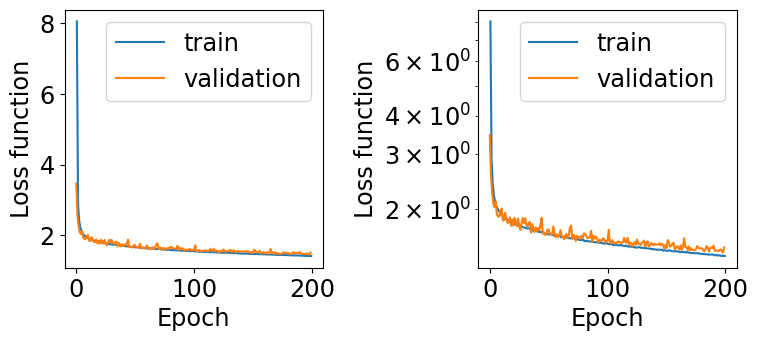

In [15]:
%%time

importlib.reload(emnist_fcn);

#model definition and training
#BEGIN_SOLUTION
inputShape = (28,28)
nNeurons = np.full((16),128)
nOutputNeurons = nCategories

model = emnist_fcn.getModel(inputShape=inputShape, nOutputNeurons=nOutputNeurons, 
                            nNeurons=nNeurons, 
                            hiddenActivation="relu", 
                            outputActivation="softmax")

#configure learning process
initial_learning_rate = 1E-3
batchSize = 64
nEpochs = 200

nStepsPerEpoch = len(x_train)/batchSize
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#run training
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, min_delta=1E-3)
callbacks = [early_stop_callback]

history = model.fit(x=x_train, y=y_train, 
                    epochs=nEpochs, 
                    batch_size = batchSize,
                    validation_split=0.1,
                    callbacks=callbacks,
                    verbose=0)
plf.plotTrainHistory(history)
print(colored("Evaluation on training dataset:","blue"))
model.evaluate(x_train, y_train)
print(colored("Evaluation on test dataset:","blue"))
model.evaluate(x_test, y_test);
#END_SOLUTION

450/450 [==============================] - 0s 855us/step


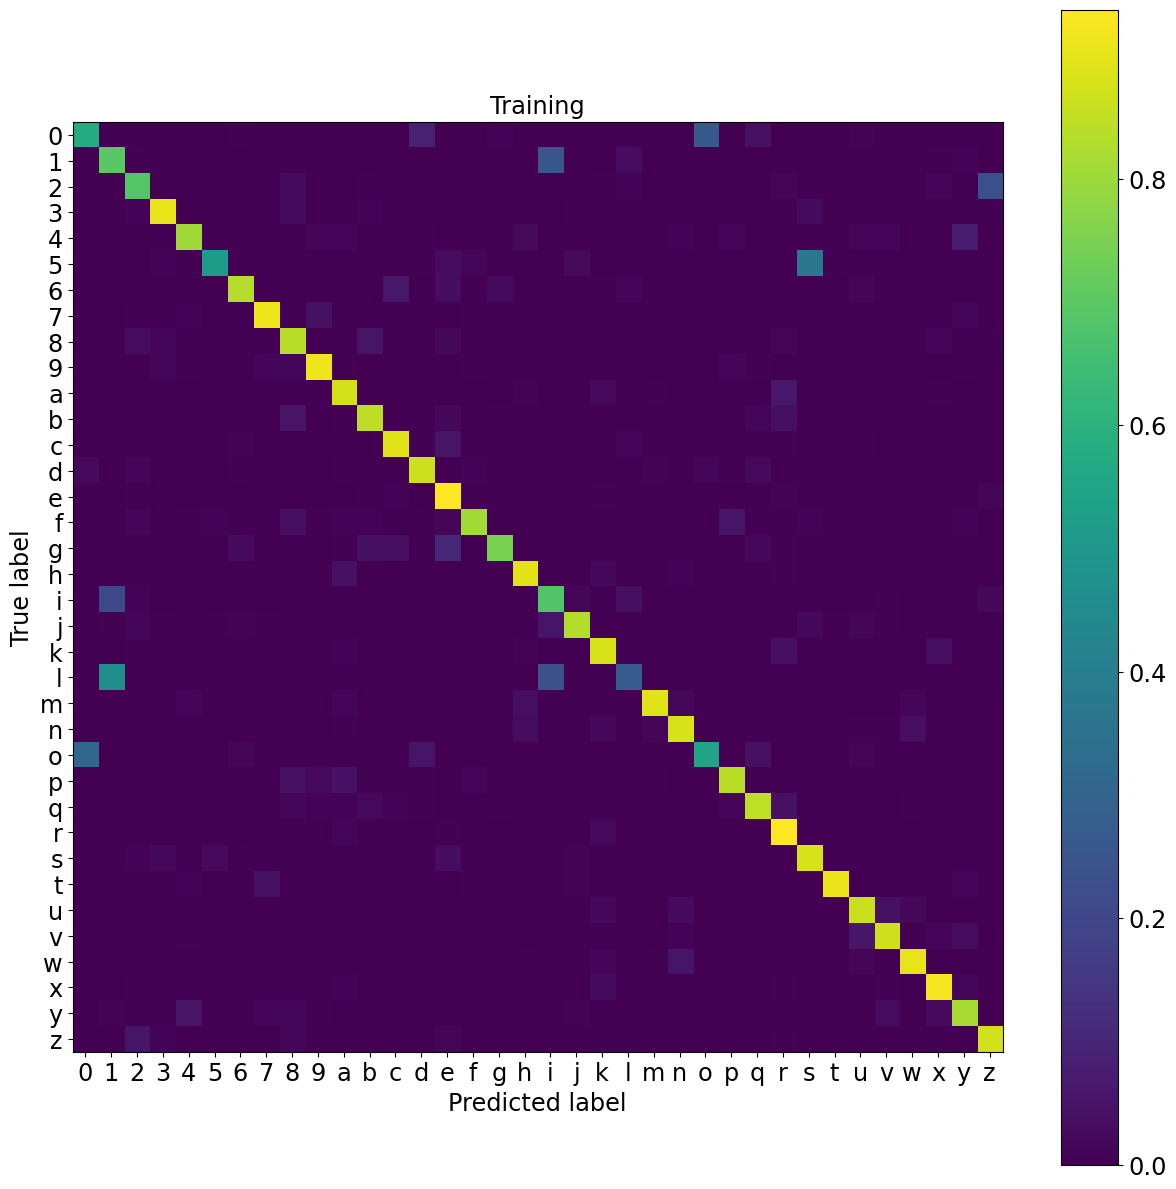

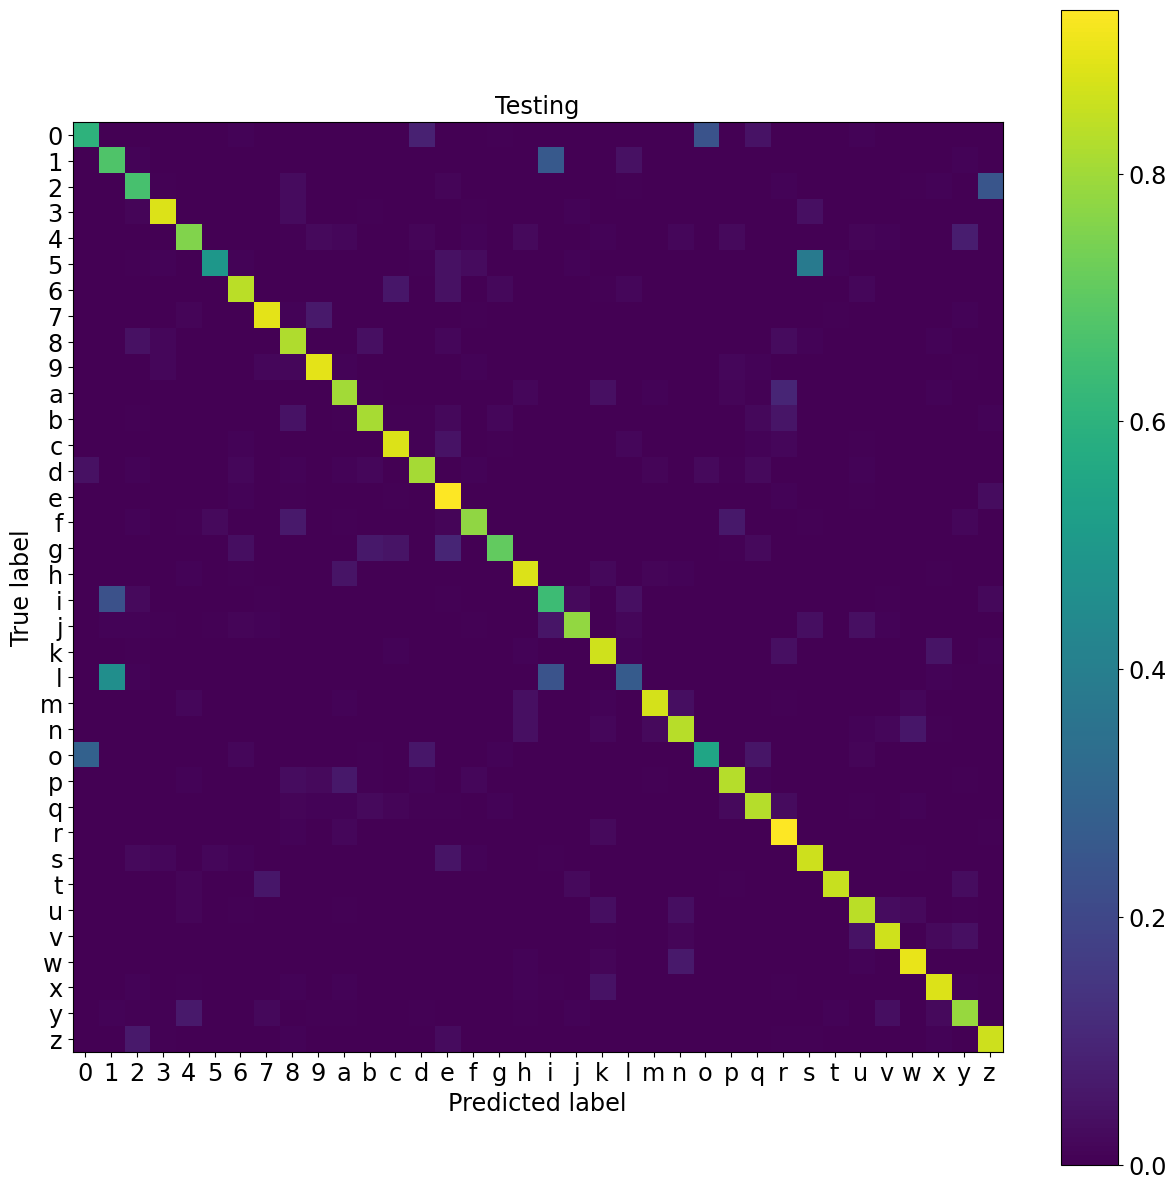

In [16]:
#evaluation
#BEGIN_SOLUTION
y_pred = tf.argmax(model.predict(x_train), axis=1)
emnist_fcn.plotMNIST_CM(y_train,y_pred,"Training")

y_pred = tf.argmax(model.predict(x_test), axis=1)
emnist_fcn.plotMNIST_CM(y_test,y_pred,"Testing")
#END_SOLUTION
pass

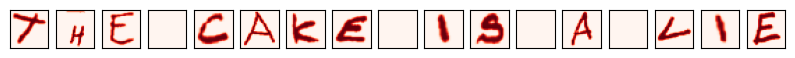

In [19]:
#BEGIN_SOLUTION
#message encoding
importlib.reload(emnist_fcn);
text = "the cake is a lie"
encoded = emnist_fcn.encodeMessage(text,x,y);

fileName = "encoded.npz"
with open(fileName, 'wb') as file:
    np.save(file, encoded)
#END_SOLUTION
pass

In [20]:
#message decoding
#BEGIN_SOLUTION
fileName = "data/encoded.npz"
with open(fileName, 'rb') as file:
    encoded = np.load(file)

spaces_mask = np.sum(encoded, axis=(1,2))>0
decoded = tf.argmax(model.predict(encoded), axis=1)
digits = [str(item) for item in range(0,10)]
letters_lower = list(string.ascii_lowercase)
digits_letters = np.array(digits + letters_lower)
decoded = digits_letters[decoded]
decoded = np.where(spaces_mask, decoded, " ")
decoded = ''.join(decoded)
print(colored("Decoded message is:","blue"),decoded)
#END_SOLUTION
pass

1/1 [==============================] - 0s 78ms/step
Decoded message is: y6e cake is a lie
